# Quantity base policy: price elasticity of carbon in EPPA

In [7]:
import pandas as pd
import pandas.io.excel
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
%matplotlib inline

In [8]:
#define main directory
#mainDir = 'C:/Users/Admin/Documents/xxx/Profession/EnergyProject/EMF/CarbonElasticity'
mainDir = 'C:/Users/Tee/Documents/xxx/EnergyProject/EMF/CarbonElasticity'

As we modify codes as explained earlier, we can run multiple scenarios in EPPA by creating .cas file for cap price path and perturbation factor, then using a script that we wrote called 'batch_quantity-based.bat' in command prompt (see detail in the file) to run multiple scenarios. For EPPA, we need to run scenarios in one batch. That batch is one without any modification on carbon accounting. That is, only fossil fuel carbon is accounted for carbon tax.

We measure both price and quantities, then stack them together as a table.

In [9]:
color = 'green' #for EPPA

In [10]:
def measure(Quantity,Model,Location,Policy,Path,perturb):
#Quantity: 'POP','GDP','PE','PRICE','CO2_FI','CO2_FOS','CO2_TOT'
#Location: 'US','global'
#Policy: 'nopolicy', 'price-based-tot', 'price-based-fos','quantity-based-tot','quantity-based-fos'
#Path: 'NA', 'step050','step100','step200',...
#perturb: 'p085',...,'p115'
#Model: 'MERGE','EPPA','GCAM'
    if Quantity == 'POP':
        if Model == 'MERGE':
            #read pop from nopolicy regardless of policy
            filename = 'pop_' + 'nopolicy' + '.xlsx'
            POP = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'MERGE' + '/' + 'nopolicy' +'/' + filename,\
                                             sheetname="Sheet2", header=None, names=["year","region","level"])
            POP['level'] = POP['level']*1000 #unit conversion to million 
            #query for USA and sum for global.
            if Location == 'US':
                pop = POP[POP.region=='USA'][['year','level']]
                pop.set_index('year',inplace=True)
                pop.columns = [perturb]
                return pop;
            if Location == 'global':
                pop = POP[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
                pop.set_index('year',inplace=True)
                pop.columns = [perturb]
                return pop;
        if Model == 'EPPA':
            #read pop from nopolicy regardless of policy
            filename = 'y_res_' + 'nopolicy' + '.xls'
            POP = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'EPPA' + '/' + 'nopolicy' +'/' + filename, sheetname="3pop")
            POP = pd.DataFrame(POP.stack()).reset_index()
            POP.columns = ['region','year','level']
            POP['level'] = POP['level']*1 #unit conversion to million
            #query for USA and sum for global.
            if Location == 'US':
                pop = POP[POP.region=='USA'][['year','level']]
                pop.set_index('year',inplace=True)
                pop.columns = [perturb]
                return pop;
            if Location == 'global':
                pop = POP[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
                pop.set_index('year',inplace=True)
                pop.columns = [perturb]
                return pop;
        if Model == 'GCAM':
            #read pop from nopolicy regardless of policy
            #need individual query for each location. US is not available right now (2016/7/17)
            if Location == 'US':
                filename = 'us_population_' + 'nopolicy'+ '.xlsx'
            if Location == 'global':
                filename = 'global_population_' + 'nopolicy'+ '.xlsx'
            table = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'GCAM/GCAM40_result' + '/'+ 'nopolicy'+'/'  + filename, sheetname="Sheet1")
            table.drop(['scenario','region','Units'],axis=1, inplace=True)
            d =table.transpose().reset_index()
            d.columns = ['year','level']
            d.level = d.level/1000 #unit conversion to million
            pop = d
            pop.set_index('year',inplace=True)
            pop.columns = [perturb]
            return pop;
            
    if Quantity == 'GDP':
        if Model == 'MERGE':
            #read GDP
            if Policy == 'nopolicy':
                filename = 'gdp_' + 'nopolicy' + '.xlsx'
            else:
                filename = 'gdp_' + Path + '_' + perturb + '.xlsx'
            GDP = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'MERGE' + '/' + Policy + '/'+ filename, \
                                  sheetname="Sheet2", header=None, names=["year","region","level"])
            GDP['level'] = GDP['level']/0.72262 #unit conversion to trillion dollars of 2005 
    
            #query for USA and sum for global.
            if Location == 'US':
                GDP_US_MERGE = GDP[GDP.region=='USA'][['year','level']]
                GDP_US = GDP_US_MERGE
                GDP_US.set_index('year',inplace=True)
                GDP_US.columns = [perturb]
                return GDP_US;
            if Location == 'global':
                GDP_global_MERGE = GDP[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
                GDP_global = GDP_global_MERGE
                GDP_global.set_index('year',inplace=True)
                GDP_global.columns = [perturb]
                return GDP_global;
        #define function to read other quantities 
        if Model == 'EPPA':
            if Policy == 'nopolicy':
                filename = 'y_res_' + 'nopolicy' + '.xls'
                directory = mainDir + '/rawresult/' + 'EPPA' + '/' + Policy + '/'
            if (Policy == 'price-based-tot')|(Policy == 'price-based-fos'):
                filename = 'y_res_test_policy_price_' + Path + '_' + perturb + '.xls'
                directory = mainDir + '/rawresult/' + 'EPPA' + '/' + Policy + '/'+ 'test_policy_price_' + Path + '_' + perturb +'/'
            if (Policy == 'quantity-based-tot')|(Policy == 'quantity-based-fos'):
                filename = 'y_res_test_policy_cap_' + Path + '_' + perturb + '.xls'
                directory = mainDir + '/rawresult/' + 'EPPA' + '/' + Policy + '/'+ 'test_policy_cap_' + Path + '_' + perturb +'/'
            GDP = pandas.io.excel.read_excel(directory + filename, sheetname="1cons")
            GDP = pd.DataFrame(GDP.stack()).reset_index()
            GDP.columns = ['region','year','level']
            GDP['level'] = GDP['level']*1/0.84628/1000 #unit conversion to trillion dollars of 2005

            #query for USA and sum for global.
            if Location == 'US':
                GDP_US_EPPA = GDP[GDP.region=='USA'][['year','level']]
                GDP_US = GDP_US_EPPA
                GDP_US.set_index('year',inplace=True)
                GDP_US.columns = [perturb]
                return GDP_US;
            if Location == 'global':
                GDP_global_EPPA = GDP[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
                GDP_global = GDP_global_EPPA
                GDP_global.set_index('year',inplace=True)
                GDP_global.columns = [perturb]
                return GDP_global;
        if Model == 'GCAM':
            #need individual query for each location. US is not available right now (2016/7/17)
            if Policy == 'nopolicy':
                if Location == 'US':
                    filename = 'us_gdp_' + 'nopolicy'+ '.xlsx'
                if Location == 'global':
                    filename = 'global_gdp_' + 'nopolicy' + '.xlsx'
            else:
                if Location == 'US':
                    filename = 'us_gdp_' + Path + '_' + perturb + '.xlsx'
                if Location == 'global':
                    filename = 'global_gdp_' + Path + '_' + perturb + '.xlsx'
            table = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'GCAM/GCAM40_result' + '/'+ Policy +'/'  + filename, sheetname="Sheet1")
            table.drop(['scenario','region','Region','Units'],axis=1, inplace=True)
            d =table.transpose().reset_index()
            d.columns = ['year','level']
            d.level = d.level/0.72262/1000000.0 #unit conversion to trillion dollars of 2005
            gdp = d
            gdp.set_index('year',inplace=True)
            gdp.columns = [perturb]
            return gdp;
            
    if Quantity == 'PE':
        if Model == 'MERGE':
            #read primary energy
            if Policy == 'nopolicy':
                filename = 'TPE_' + 'nopolicy' + '.xlsx'
            else:
                filename = 'TPE_' + Path + '_' + perturb + '.xlsx'
            PE = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'MERGE' + '/' + Policy + '/'+ filename, \
                                          sheetname="Sheet2")
            PE = PE.reset_index()
            PE.drop(['level_0','level_3','Marginal','Lower','Upper'],axis=1, inplace=True)
            PE.columns = ['year','region','level']
            #PE['level'] = PE['level']*1 #unit conversion to EJ
    
            #query for USA and sum for global.
            if Location == 'US':
                #Note we need to sum over types of generation as well
                PE_US_MERGE = PE[PE.region=='USA'][['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
                PE_US = PE_US_MERGE
                PE_US.set_index('year',inplace=True)
                PE_US.columns = [perturb]
                return PE_US;
            if Location == 'global':
                PE_global_MERGE = PE[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
                PE_global = PE_global_MERGE
                PE_global.set_index('year',inplace=True)
                PE_global.columns = [perturb]
                return PE_global;
        if Model == 'EPPA':
            if Policy == 'nopolicy':
                filename = 'y_res_' + 'nopolicy' + '.xls'
                directory = mainDir + '/rawresult/' + 'EPPA' + '/' + Policy + '/'
            if (Policy == 'price-based-tot')|(Policy == 'price-based-fos'):
                filename = 'y_res_test_policy_price_' + Path + '_' + perturb + '.xls'
                directory = mainDir + '/rawresult/' + 'EPPA' + '/' + Policy + '/'+ 'test_policy_price_' + Path + '_' + perturb +'/'
            if (Policy == 'quantity-based-tot')|(Policy == 'quantity-based-fos'):
                filename = 'y_res_test_policy_cap_' + Path + '_' + perturb + '.xls'
                directory = mainDir + '/rawresult/' + 'EPPA' + '/' + Policy + '/'+ 'test_policy_cap_' + Path + '_' + perturb +'/'
            PE = pandas.io.excel.read_excel(directory + filename, sheetname="5ener")
            PE = pd.DataFrame(PE.stack()).reset_index()
            PE.columns = ['region','type','year','level']
            PE['level'] = PE['level']*1 #unit conversion to trillion dollars of 2005
            PE.loc[PE['level']=='Eps','level'] = 0 #Fix the unknown to zero

            #query for USA and sum for global.
            #Note we need to sum over types of generation as well
            if Location == 'US':
                PE_US_EPPA = PE[PE.region=='USA'][['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
                PE_US = PE_US_EPPA
                PE_US.set_index('year',inplace=True)
                PE_US.columns = [perturb]
                return PE_US;
            if Location == 'global':
                PE_global_EPPA = PE[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
                PE_global = PE_global_EPPA
                PE_global.set_index('year',inplace=True)
                PE_global.columns = [perturb]
                return PE_global;
        if Model == 'GCAM':
            #need individual query for each location. US is not available right now (2016/7/17)
            if Policy == 'nopolicy':
                if Location == 'US':
                    filename = 'us_pe_' + 'nopolicy'+ '.xlsx'
                if Location == 'global':
                    filename = 'global_pe_' + 'nopolicy' + '.xlsx'
            else:
                if Location == 'US':
                    filename = 'us_pe_' + Path + '_' + perturb + '.xlsx'
                if Location == 'global':
                    filename = 'global_pe_' + Path + '_' + perturb + '.xlsx'
            table = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'GCAM/GCAM40_result' + '/'+ Policy +'/'  + filename, sheetname="Sheet1")
            table.drop(['scenario','region','Units','fuel'],axis=1, inplace=True)
            d =table.transpose()
            d =d.sum(axis=1).reset_index()
            d.columns = ['year','level']
            d.level = d.level*1 #unit conversion to trillion dollars of 2005
            pe = d
            pe.set_index('year',inplace=True)
            pe.columns = [perturb]
            return pe;
            
            
    if Quantity == 'PRICE':
        if Model == 'MERGE':
            if Policy == 'nopolicy':
                return 0; #there is no price quantity for nopolicy scenario
            else:
                filename = 'dual_' + Path + '_' + perturb + '.xlsx'
                dual = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'MERGE' + '/' + Policy + '/' +filename,\
                                      sheetname="Sheet2", header = None)
                dual.columns = ['year','region','type','price']
                def Conversion(x):
                    if x=='Eps':
                        x = float('NaN')
                    else:
                        x = float(x)*12/44/0.88723
                    return x;
                dual['price'] = dual['price'].map(lambda x: Conversion(x))
                p = dual[(dual.region=='USA')&(dual.type=='carbon')][['year','price']]
                p.set_index('year',inplace=True)
                p.columns = [perturb]
                return p; #This is price for both locations 
        if Model == 'EPPA':
            if Policy == 'nopolicy':
                return 0; #there is no price quantity for nopolicy scenario
            else:
                if (Policy == 'price-based-tot')|(Policy == 'price-based-fos'):
                    filename = 'y_res_test_policy_price_' + Path + '_' + perturb + '.xls'
                    directory = mainDir + '/rawresult/' + 'EPPA' + '/' + Policy + '/'+ 'test_policy_price_' + Path + '_' + perturb +'/'
                if (Policy == 'quantity-based-tot')|(Policy == 'quantity-based-fos'):
                    filename = 'y_res_test_policy_cap_' + Path + '_' + perturb + '.xls'
                    directory = mainDir + '/rawresult/' + 'EPPA' + '/' + Policy + '/'+ 'test_policy_cap_' + Path + '_' + perturb +'/'
                cbtax = pandas.io.excel.read_excel(directory + filename, sheetname="9c_price")
                cbtax = pd.DataFrame(cbtax.stack()).reset_index()
                cbtax.columns = ['region','year','price']
                cbtax['price'] = cbtax['price']/0.84628
                cbtax['year'] = list(cbtax['year'].map(lambda x: float(x)))
                p = cbtax[(cbtax.region=='USA')][['year','price']]
                p.set_index('year',inplace=True)
                p.columns = [perturb]
                return p; #This is price for both locations
        if Model == 'GCAM':
            if Policy == 'nopolicy':
                return 0; #there is no price quantity for nopolicy scenario
            else:
                filename = 'co2price_' + Path + '_' + perturb + '.xlsx'
                co2price = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'GCAM/GCAM40_result' + '/' + Policy +'/' + filename, sheetname="Sheet1")
                co2price.drop(['scenario','market','Units'],axis=1,inplace=True)
                co2price.set_index('region',inplace=True)
                co2price = pd.DataFrame(co2price.stack()).reset_index()
                co2price.columns = ['region','year','price']
                co2price['price'] = co2price['price']*12/44/0.72262 #unit conversion to 2005 dollars per CO2 ton
                p = co2price[co2price.region=='Global'][['year','price']]
                p.set_index('year',inplace=True)
                p.columns = [perturb]
                return p; #This is price for both locations
    
    if (Quantity == 'CO2_FI')|(Quantity == 'CO2_FOS')|(Quantity == 'CO2_TOT'):
        if Model == 'MERGE':
            #read CLEV
            if Policy == 'nopolicy':
                filename = 'CLEV_' + 'nopolicy' + '.xlsx'
            else:
                filename = 'CLEV_' + Path + '_' + perturb + '.xlsx'
            CLEV = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'MERGE' + '/' + Policy + '/'+ filename, \
                                          sheetname="Sheet2")
            CLEV.reset_index(inplace = True)
            CLEV = CLEV.rename(columns = {'level_0':'year'})
            CLEV = CLEV.rename(columns = {'level_1':'region'})
            CLEV['Level'] = CLEV['Level']*1000*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)

            #read CCEM
            if Policy == 'nopolicy':
                filename = 'CCEM_' + 'nopolicy' + '.xlsx'
            else:
                filename = 'CCEM_' + Path + '_' + perturb + '.xlsx'
            CCEM = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'MERGE' + '/' + Policy + '/'+ filename, \
                                              sheetname="Sheet2")
            CCEM.reset_index(inplace = True)
            CCEM = CCEM.rename(columns = {'level_0':'year'})
            CCEM = CCEM.rename(columns = {'level_1':'region'})
            CCEM['Level'] = CCEM['Level']*1000*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)

            #read CFOS
            if Policy == 'nopolicy':
                filename = 'CFOS_' + 'nopolicy' + '.xlsx'
            else:
                filename = 'CFOS_' + Path + '_' + perturb + '.xlsx'
            CFOS = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'MERGE' + '/' + Policy + '/'+ filename, \
                                              sheetname="Sheet2")
            CFOS.reset_index(inplace = True)
            CFOS = CFOS.rename(columns = {'level_0':'year'})
            CFOS = CFOS.rename(columns = {'level_1':'region'})
            CFOS['Level'] = CFOS['Level']*1000*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)

            #CFOS is computed since 2020
            CFI = CCEM[CCEM.columns.values]
            CFI = CFI[CFI.year>=2020].reset_index(drop=True)
            CFI['Level'] = CFI['Level']+CFOS['Level']
            #compute CTOT
            CTOT = CLEV[CLEV.columns.values]
            CTOT['Level'] = CCEM['Level']+CLEV['Level']

            #rename CFOS, CFI, and CTOT
            CFOS=CFOS.rename(columns = {'Level':'level'})
            CFI=CFI.rename(columns = {'Level':'level'})
            CTOT=CTOT.rename(columns = {'Level':'level'})
            
            if Location == 'US':
                if Quantity == 'CO2_FOS':
                    qUS_fos = CFOS[CFOS.region=='USA'][['year','level']]
                    qUS_fos.set_index('year',inplace=True)
                    qUS_fos.columns = [perturb]
                    return qUS_fos;
                if Quantity == 'CO2_FI':
                    qUS_fi = CFI[CFI.region=='USA'][['year','level']]
                    qUS_fi.set_index('year',inplace=True)
                    qUS_fi.columns = [perturb]
                    return qUS_fi;
                if Quantity == 'CO2_TOT':
                    qUS_tot = CTOT[CTOT.region=='USA'][['year','level']]
                    qUS_tot.set_index('year',inplace=True)
                    qUS_tot.columns = [perturb]
                    return qUS_tot;
            if Location == 'global':
                if Quantity == 'CO2_FOS':
                    qglobal_fos = CFOS[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
                    qglobal_fos.set_index('year',inplace=True)
                    qglobal_fos.columns = [perturb]
                    return qglobal_fos;
                if Quantity == 'CO2_FI':
                    qglobal_fi = CFI[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
                    qglobal_fi.set_index('year',inplace=True)
                    qglobal_fi.columns = [perturb]
                    return qglobal_fi;
                if Quantity == 'CO2_TOT':
                    qglobal_tot = CTOT[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
                    qglobal_tot.set_index('year',inplace=True)
                    qglobal_tot.columns = [perturb]
                    return qglobal_tot;
        if Model == 'EPPA':
            if Policy == 'nopolicy':
                filename = 'y_emit_' + 'nopolicy' + '.xls'
                directory = mainDir + '/rawresult/' + 'EPPA' + '/' + Policy + '/'
            if (Policy == 'price-based-tot')|(Policy == 'price-based-fos'):
                filename = 'y_emit_test_policy_price_' + Path + '_' + perturb + '.xls'
                directory = mainDir + '/rawresult/' + 'EPPA' + '/' + Policy + '/'+ 'test_policy_price_' + Path + '_' + perturb +'/'
            if (Policy == 'quantity-based-tot')|(Policy == 'quantity-based-fos'):
                filename = 'y_emit_test_policy_cap_' + Path + '_' + perturb + '.xls'
                directory = mainDir + '/rawresult/' + 'EPPA' + '/' + Policy + '/'+ 'test_policy_cap_' + Path + '_' + perturb +'/'
            #total carbon emission
            CTOT = pandas.io.excel.read_excel(directory + filename, sheetname="5tot_co2")
            CTOT = pd.DataFrame(CTOT.stack()).reset_index()
            CTOT.columns = ['region','year','level']
            CTOT['level'] = CTOT['level'] #unit conversion to million ton of CO2 (MMtCO2)
            CTOT['year'] = list(CTOT['year'].map(lambda x: float(x)))

            #fossil + industry carbon emission
            CFI = pandas.io.excel.read_excel(directory + filename, sheetname="4fi_co2")
            CFI = pd.DataFrame(CFI.stack()).reset_index()
            CFI.columns = ['region','year','level']
            CFI['level'] = CFI['level'] #unit conversion to million ton of CO2 (MMtCO2)
            CFI['year'] = list(CFI['year'].map(lambda x: float(x)))

            #fossil carbon emission
            CFOS = pandas.io.excel.read_excel(directory + filename, sheetname="3fos_co2")
            CFOS = pd.DataFrame(CFOS.stack()).reset_index()
            CFOS.columns = ['region','year','level']
            CFOS['level'] = CFOS['level'] #unit conversion to million ton of CO2 (MMtCO2)
            CFOS['year'] = list(CFOS['year'].map(lambda x: float(x)))
            
            if Location == 'US':
                if Quantity == 'CO2_FOS':
                    qUS_fos = CFOS[CFOS.region=='USA'][['year','level']]
                    qUS_fos.set_index('year',inplace=True)
                    qUS_fos.columns = [perturb]
                    return qUS_fos;
                if Quantity == 'CO2_FI':
                    qUS_fi = CFI[CFI.region=='USA'][['year','level']]
                    qUS_fi.set_index('year',inplace=True)
                    qUS_fi.columns = [perturb]
                    return qUS_fi;
                if Quantity == 'CO2_TOT':
                    qUS_tot = CTOT[CTOT.region=='USA'][['year','level']]
                    qUS_tot.set_index('year',inplace=True)
                    qUS_tot.columns = [perturb]
                    return qUS_tot;
            if Location == 'global':
                if Quantity == 'CO2_FOS':
                    qglobal_fos = CFOS[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
                    qglobal_fos.set_index('year',inplace=True)
                    qglobal_fos.columns = [perturb]
                    return qglobal_fos;
                if Quantity == 'CO2_FI':
                    qglobal_fi = CFI[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
                    qglobal_fi.set_index('year',inplace=True)
                    qglobal_fi.columns = [perturb]
                    return qglobal_fi;
                if Quantity == 'CO2_TOT':
                    qglobal_tot = CTOT[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
                    qglobal_tot.set_index('year',inplace=True)
                    qglobal_tot.columns = [perturb]
                return qglobal_tot;
        if Model == 'GCAM':
            #Define types of carbon emission in GCAM4.0. If it is not clear, assume it is fossil fuel
            FOSlist =[u'3W Rural', u'Bus', u'Compact Car', u'Domestic Aviation', u'Domestic Ship', u'Freight Rail',
             u'Heavy Bus', u'International Aviation',u'International Ship', u'Large Car',u'Large Car and SUV', u'Light Bus',
             u'Light Truck and SUV', u'Midsize Car',u'Mini Car',u'Moped',u'Motorcycle (50-250cc)',u'Motorcycle (>250cc)',
             u'Multipurpose Vehicle', u'Passenger Rail',u'Scooter',u'Subcompact Car',u'Three-Wheeler',u'Truck',u'Truck (0-1t)',
             u'Truck (0-2.7t)',u'Truck (0-2t)',u'Truck (0-3.5t)',u'Truck (0-4.5t)',u'Truck (0-6t)',u'Truck (1-6t)',u'Truck (16-32t)',
             u'Truck (2-5t)',u'Truck (2.7-4.5t)', u'Truck (3.5-16t)', u'Truck (4.5-12t)', u'Truck (4.5-15t)',
             u'Truck (5-9t)', u'Truck (6-14t)', u'Truck (6-15t)', u'Truck (6-30t)', u'Truck (9-16t)', u'Truck (>12t)', u'Truck (>14t)',
                u'Truck (>15t)', u'Truck (>32t)', u'Van',u'coal', u'coal gasification', u'coal to liquids', u'gas', u'gas pipeline',
                u'gas to liquids',u'unconventional oil production',u'oil refining', u'refined liquids']
            FIlist = FOSlist + [u'cement']
            TOTlist = FIlist + [u'biomass', u'biomass gasification', u'biomass liquids',
             'land-use', u'regional biomass', u'regional biomassOil', u'regional corn for ethanol', u'regional sugar for ethanol']

            #Define types of carbon emission as in GCAM3.2
            #'''
            #FOSlist = [u'LDV', u'air', u'bus', u'coal', u'coal chemical', u'coal gasification', u'coal to liquids', u'domestic ship', u'gas',\
            # u'gas chemical', u'gas pipeline', u'gas to liquids', u'international ship', u'oil', u'oil refining', u'rail', u'refined liquids',\
            # u'road', u'unconventional oil production']
            #FIlist = FOSlist + [u'cement (conv)', u'cement_CCS']
            #TOTlist = FIlist + [u'biomass', u'biomass gasification',  u'biomass liquids', u'biomass to H2','land-use',u'regional biomass',\
            # u'regional biomassOil', u'regional corn for ethanol', u'regional sugar for ethanol', u'regional sugarbeet for ethanol']
            # '''

            #Global
            #need individual query for each location. US is not available right now (2016/7/17)
            if Policy == 'nopolicy':
                if Location == 'US':
                    filename1 = 'us_landuse_' + 'nopolicy' + '.xlsx'
                    filename2 = 'us_subsector_' + 'nopolicy' + '.xlsx'
                if Location == 'global':
                    filename1 = 'global_landuse_' + 'nopolicy' + '.xlsx'
                    filename2 = 'global_subsector_' + 'nopolicy' + '.xlsx'
            else:
                if Location == 'US':
                    filename1 = 'us_landuse_' + Path + '_' + perturb + '.xlsx'
                    filename2 = 'us_subsector_' + Path + '_' + perturb + '.xlsx'
                if Location == 'global':
                    filename1 = 'global_landuse_' + Path + '_' + perturb + '.xlsx'
                    filename2 = 'global_subsector_' + Path + '_' + perturb + '.xlsx'
                    
            #this is for land use change emission
            table1 = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'GCAM/GCAM40_result' + '/'+ Policy +'/'  + filename1, sheetname="Sheet1")
            table1.drop(['scenario','region','land-use-change-emission','Units',1980,1985,1995,2000],axis=1, inplace=True)
            table1['subsector'] = ['land-use']
            #this is for other emission
            table2 = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'GCAM/GCAM40_result' + '/'+ Policy +'/'  + filename2, sheetname="Sheet1")
            table2.drop(['scenario','region','sector','Units'],axis=1, inplace=True)
            table = pd.concat([table1,table2])
            global_table = table
            if Quantity == 'CO2_FOS':
                d =pd.DataFrame(table[table.subsector.map(lambda x: x in FOSlist)].drop(['subsector'],axis=1).sum(axis=0),columns=['level']).reset_index()
                d.columns = ['year','level']
                d.level = d.level*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)
                d.set_index('year',inplace=True)
                d.columns = [perturb]
                return d;
            if Quantity == 'CO2_FI':
                d =pd.DataFrame(table[table.subsector.map(lambda x: x in FIlist)].drop(['subsector'],axis=1).sum(axis=0),columns=['level']).reset_index()
                d.columns = ['year','level']
                d.level = d.level*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)
                d.set_index('year',inplace=True)
                d.columns = [perturb]
                return d;
            if Quantity == 'CO2_TOT':
                d =pd.DataFrame(table[table.subsector.map(lambda x: x in TOTlist)].drop(['subsector'],axis=1).sum(axis=0),columns=['level']).reset_index()
                d.columns = ['year','level']
                d.level = d.level*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)
                d.set_index('year',inplace=True)
                d.columns = [perturb]
                return d;

In [11]:
def construct_table(Quantity,Model,Location,Policy,Path):
    xtable = pd.DataFrame()
    for perturb in ['p085','p090','p095','p100','p105','p110','p115']:
        x = measure(Quantity,Model,Location,Policy,Path,perturb)
        xtable = pd.concat([xtable,x],axis=1)

    return xtable;


## EPPA > QUANTITY-BASED > TOT (non-default for EPPA) > GLOBAL 

Here we plot all types of carbon emission with different perturbations under different step caps.

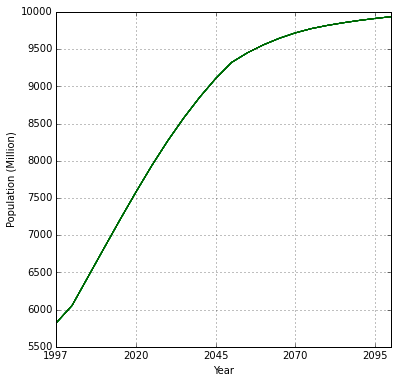

In [12]:
#population
df1 = construct_table('POP','EPPA','global','quantity-based-tot','cap500')
df2 = construct_table('POP','EPPA','global','quantity-based-tot','cap400')
df3 = construct_table('POP','EPPA','global','quantity-based-tot','cap300')
fig = plt.figure(figsize=(6,6))
ax1  = fig.add_subplot(111)
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='lightgreen',linestyle='-')
for i in df2.columns.values:
        df2[i].plot(legend=False,color ='mediumspringgreen',linestyle='-')
for i in df3.columns.values:
        df3[i].plot(legend=False,color ='darkgreen',linestyle='-')
ax1.set_ylabel('Population (Million)')
ax1.set_xlabel('Year')
#ax1.set_xlim(1990,2100)
#ax1.set_ylim(0,100000)

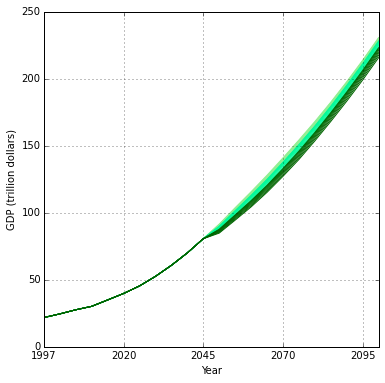

In [13]:
#GDP
df1 = construct_table('GDP','EPPA','global','quantity-based-tot','cap500')
df2 = construct_table('GDP','EPPA','global','quantity-based-tot','cap400')
df3 = construct_table('GDP','EPPA','global','quantity-based-tot','cap300')
fig = plt.figure(figsize=(6,6))
ax1  = fig.add_subplot(111)
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='lightgreen',linestyle='-')
for i in df2.columns.values:
        df2[i].plot(legend=False,color ='mediumspringgreen',linestyle='-')
for i in df3.columns.values:
        df3[i].plot(legend=False,color ='darkgreen',linestyle='-')
ax1.set_ylabel('GDP (trillion dollars)')
ax1.set_xlabel('Year')
#ax1.set_xlim(1990,2100)
#ax1.set_ylim(0,100000)

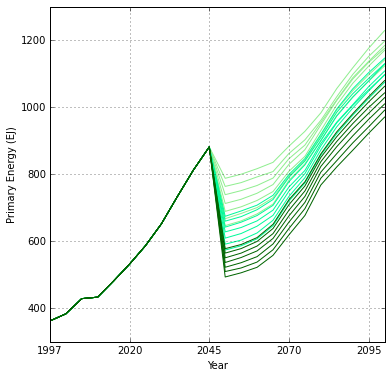

In [14]:
#PE
df1 = construct_table('PE','EPPA','global','quantity-based-tot','cap500')
df2 = construct_table('PE','EPPA','global','quantity-based-tot','cap400')
df3 = construct_table('PE','EPPA','global','quantity-based-tot','cap300')
fig = plt.figure(figsize=(6,6))
ax1  = fig.add_subplot(111)
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='lightgreen',linestyle='-')
for i in df2.columns.values:
        df2[i].plot(legend=False,color ='mediumspringgreen',linestyle='-')
for i in df3.columns.values:
        df3[i].plot(legend=False,color ='darkgreen',linestyle='-')
ax1.set_ylabel('Primary Energy (EJ)')
ax1.set_xlabel('Year')
#ax1.set_xlim(1990,2100)
#ax1.set_ylim(0,100000)


(0, 100000)

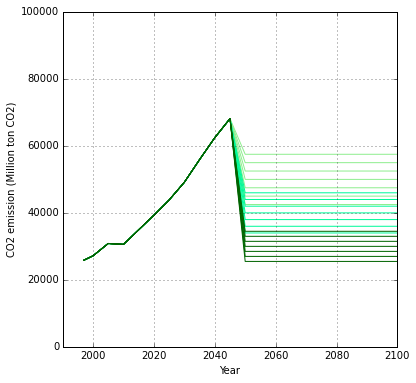

In [15]:
#Carbon Emission (Total)
df1 = construct_table('CO2_TOT','EPPA','global','quantity-based-tot','cap500')
df2 = construct_table('CO2_TOT','EPPA','global','quantity-based-tot','cap400')
df3 = construct_table('CO2_TOT','EPPA','global','quantity-based-tot','cap300')
fig = plt.figure(figsize=(6,6))
ax1  = fig.add_subplot(111)
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='lightgreen',linestyle='-')
for i in df2.columns.values:
        df2[i].plot(legend=False,color ='mediumspringgreen',linestyle='-')
for i in df3.columns.values:
        df3[i].plot(legend=False,color ='darkgreen',linestyle='-')
ax1.set_ylabel('CO2 emission (Million ton CO2)')
ax1.set_xlabel('Year')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,100000)

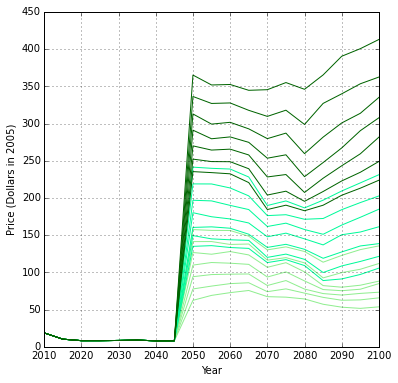

In [16]:
#Price
df1 = construct_table('PRICE','EPPA','global','quantity-based-tot','cap500')
df2 = construct_table('PRICE','EPPA','global','quantity-based-tot','cap400')
df3 = construct_table('PRICE','EPPA','global','quantity-based-tot','cap300')
fig = plt.figure(figsize=(6,6))
ax1  = fig.add_subplot(111)
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='lightgreen',linestyle='-')
for i in df2.columns.values:
        df2[i].plot(legend=False,color ='mediumspringgreen',linestyle='-')
for i in df3.columns.values:
        df3[i].plot(legend=False,color ='darkgreen',linestyle='-')
ax1.set_ylabel('Price (Dollars in 2005)')
ax1.set_xlabel('Year')
#ax1.set_xlim(1990,2100)
#ax1.set_ylim(0,100000)

# STOP HERE

Since EPPA accounts only fossil fuel carbon emission, it makes sense to use fossil fuel carbon emission as $q$. Here we do regression between $\log{p}$ and $\log{q}$ to measure elasticity. Note that EPPA does not have foresight, so the carbon emission change sharply in 2050. Here we start measuring price elasticity of carbon emission in 2050.

In [9]:
def constructelasticity_table(p,q):
    elasticity_table = pd.DataFrame(columns = ('year','value','lower','upper'))
    yearlist = [2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100]
    for i in range(0,len(yearlist)):
        x = np.log10(np.array(p[p.index==yearlist[i]]))[0]
        y = np.log10(np.array(q[q.index==yearlist[i]]))[0]
        X = sm.add_constant(x)
        model = sm.OLS(y, X)
        results = model.fit()
        elasticity_table.loc[i] = [yearlist[i], results.params[1]]+list(results.conf_int()[1])
    return elasticity_table;

In [10]:
def accumulated_elasticity(p,q):
    x = np.log10(np.array(p[p.index>=2050].sum(axis=0)))
    #y = np.log10(np.array(q[q.index==yearlist[i]]))[0]
    y = np.log10(np.array(q[q.index>=2050].sum(axis=0)))
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    results = model.fit()
    l = [results.params[1]]+list(results.conf_int()[1])
    return [l[0],(l[2]-l[1])*0.5];

(-4, 0)

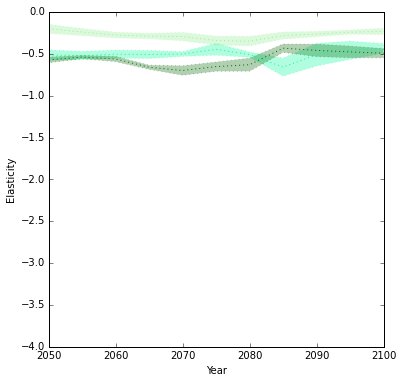

In [11]:
#fig = plt.figure(figsize=(3,8))

#ax1  = fig.add_subplot(211)
#fig = plt.figure(figsize=(3,8))
fig = plt.figure(figsize=(6,6))

ax1  = fig.add_subplot(111)
#ax1  = fig.add_subplot(211)

elasticity_table = constructelasticity_table(p_cap500,qglobal_fos_cap500)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='lightgreen',linestyle=':')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='lightgreen',linestyle=':', alpha=0.3)   
elasticity_table = constructelasticity_table(p_cap400,qglobal_fos_cap400)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='mediumspringgreen',linestyle=':')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='mediumspringgreen',linestyle=':', alpha=0.3)  
elasticity_table = constructelasticity_table(p_cap300,qglobal_fos_cap300)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='darkgreen',linestyle=':')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='darkgreen',linestyle=':', alpha=0.3)          

ax1.set_ylabel('Elasticity')
ax1.set_xlabel('Year')
#ax1.set_title(CarbonAccounting +': global')
ax1.set_ylim(-4,0)

In [13]:
accumulated_elasticity(p_cap500,qglobal_fos_cap500)

[-0.26748485819253887, 0.041151176293088079]

In [14]:
accumulated_elasticity(p_cap400,qglobal_fos_cap400)

[-0.50507723699471718, 0.037273110391527142]

In [15]:
accumulated_elasticity(p_cap300,qglobal_fos_cap300)

[-0.55322701873393854, 0.035447449001485665]

## Alternative option: accounting all carbon emission (TOT)

This is total carbon emission. Confirmation is needed.

In [16]:
CarbonAccounting = 'quantity-based-tot' # 'price' vs. 'quantity' and tot' vs. 'fos'

#p_cap600, qUS_tot_cap600, qglobal_tot_cap600, qUS_fi_cap600, qglobal_fi_cap600, qUS_fos_cap600, qglobal_fos_cap600 = constructpq_table('cap600')
p_cap500, qUS_tot_cap500, qglobal_tot_cap500, qUS_fi_cap500, qglobal_fi_cap500, qUS_fos_cap500, qglobal_fos_cap500 = constructpq_table('cap500')
p_cap400, qUS_tot_cap400, qglobal_tot_cap400, qUS_fi_cap400, qglobal_fi_cap400, qUS_fos_cap400, qglobal_fos_cap400 = constructpq_table('cap400')
p_cap300, qUS_tot_cap300, qglobal_tot_cap300, qUS_fi_cap300, qglobal_fi_cap300, qUS_fos_cap300, qglobal_fos_cap300 = constructpq_table('cap300')


Here we plot all types of carbon emission with different perturbations under different step prices.

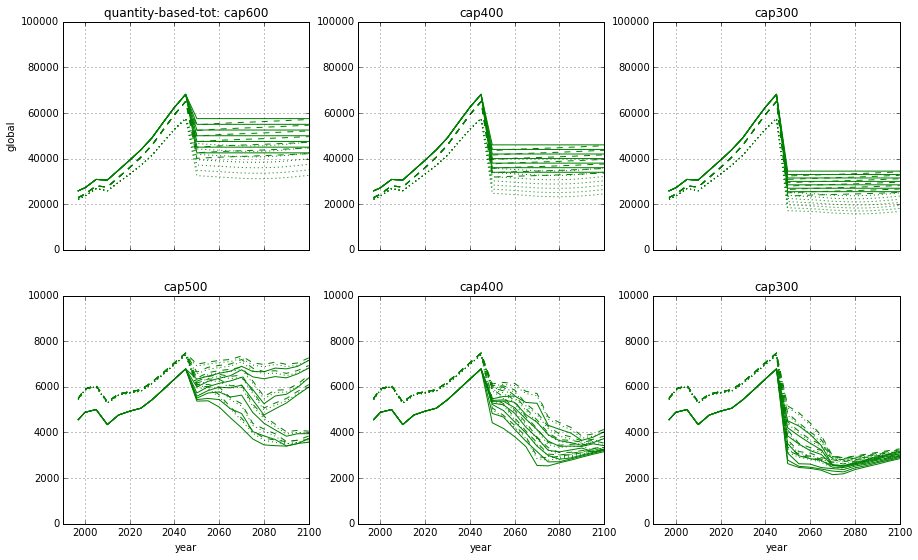

In [17]:
fig = plt.figure(figsize=(15,9))

ax1  = fig.add_subplot(231)
q_plot(qglobal_tot_cap500,qglobal_fi_cap500,qglobal_fos_cap500)
ax1.set_title(CarbonAccounting +': cap600')
ax1.set_ylabel('global')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,100000)

ax1  = fig.add_subplot(232)
q_plot(qglobal_tot_cap400,qglobal_fi_cap400,qglobal_fos_cap400)
ax1.set_title('cap400')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,100000)

ax1  = fig.add_subplot(233)
q_plot(qglobal_tot_cap300,qglobal_fi_cap300,qglobal_fos_cap300)
ax1.set_title('cap300')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,100000)

ax1  = fig.add_subplot(234)
q_plot(qUS_tot_cap500,qUS_fi_cap500,qUS_fos_cap500)
ax1.set_title('cap500')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,10000)

ax1  = fig.add_subplot(235)
q_plot(qUS_tot_cap400,qUS_fi_cap400,qUS_fos_cap400)
ax1.set_title('cap400')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,10000)

ax1  = fig.add_subplot(236)
q_plot(qUS_tot_cap300,qUS_fi_cap300,qUS_fos_cap300)
ax1.set_title('cap300')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,10000)

fig.show()

(1990, 2100)

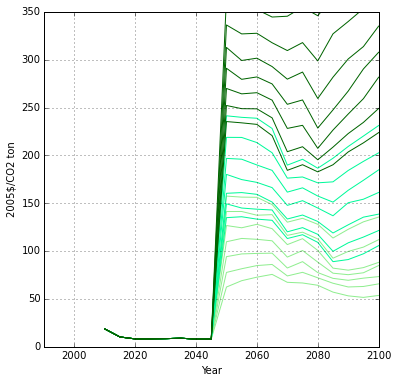

In [18]:

fig = plt.figure(figsize=(6,6))
ax1  = fig.add_subplot(111)
df1 = p_cap500
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='lightgreen',linestyle='-')
df1 = p_cap400
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='mediumspringgreen',linestyle='-')
df1 = p_cap300
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='darkgreen',linestyle='-')
ax1.set_ylabel('2005$/CO2 ton')
ax1.set_ylim(0,350)
ax1.set_xlabel('Year')
ax1.set_xlim(1990,2100)

In the second batch (account total carbon in cap), it makes sense to use total fuel carbon emission as $q$. Here we do regression between $\log{p}$ and $\log{q}$ to measure elasticity. Note that EPPA has no perfect foresight, so the carbon emission changes in 2050. Here we start measuring price elasticity of carbon emission in 2050.


(-4, 0)

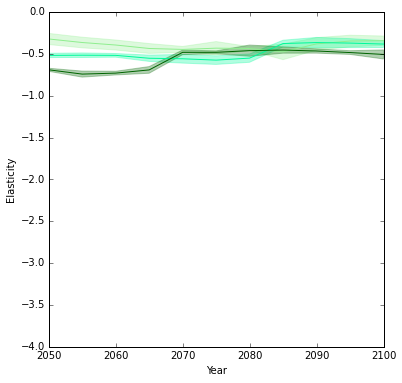

In [20]:
#fig = plt.figure(figsize=(3,8))
fig = plt.figure(figsize=(6,6))

ax1  = fig.add_subplot(111)
#ax1  = fig.add_subplot(211)

elasticity_table = constructelasticity_table(p_cap500,qglobal_tot_cap500)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='lightgreen')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='lightgreen', alpha=0.3)   
elasticity_table = constructelasticity_table(p_cap400,qglobal_tot_cap400)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='mediumspringgreen')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='mediumspringgreen', alpha=0.3)  
elasticity_table = constructelasticity_table(p_cap300,qglobal_tot_cap300)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='darkgreen')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='darkgreen', alpha=0.3)          
ax1.set_ylabel('Elasticity')
ax1.set_xlabel('Year')
#ax1.set_title(CarbonAccounting +': global')
ax1.set_ylim(-4,0)


In [22]:
accumulated_elasticity(p_cap500,qglobal_tot_cap500)

[-0.39751490292018765, 0.034515847991549442]

In [23]:
accumulated_elasticity(p_cap400,qglobal_tot_cap400)

[-0.47214146008991165, 0.02839537284798152]

In [24]:
accumulated_elasticity(p_cap300,qglobal_fos_cap300)

[-0.71706210644452462, 0.012883703420461745]